In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import zipfile
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class HARModel:
    def __init__(self):
        self.scaler = None
        self.model = None
        self.selected_features = None

    def download_and_prepare_data(self, download_url=None):
        """Download and prepare the UCI HAR dataset."""
        print("Downloading and preparing the UCI HAR dataset...")

        # If no URL is provided, use the default UCI HAR dataset URL
        if not download_url:
            download_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"

        # Download and extract the dataset
        zip_path = "uci_har_dataset.zip"
        urllib.request.urlretrieve(download_url, zip_path)

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(".")

        # Load training data
        X_train = np.loadtxt("UCI HAR Dataset/train/X_train.txt")
        y_train = np.loadtxt("UCI HAR Dataset/train/y_train.txt")

        # Load test data
        X_test = np.loadtxt("UCI HAR Dataset/test/X_test.txt")
        y_test = np.loadtxt("UCI HAR Dataset/test/y_test.txt")

        # Load feature names
        with open("UCI HAR Dataset/features.txt") as f:
            features = [line.split()[1] for line in f.readlines()]

        # Convert to binary classification: human activity vs non-human
        # For demonstration, let's consider activities 1-3 as "human" (1) and 4-6 as "non-human" (0)
        # In a real scenario, you would define this differently based on your needs
        y_train_binary = np.where(y_train <= 3, 1, 0)
        y_test_binary = np.where(y_test <= 3, 1, 0)

        # Clean up
        os.remove(zip_path)

        return X_train, y_train_binary, X_test, y_test_binary, features

    def select_thermal_relevant_features(self, features):
        """Select features that might be relevant for thermal data integration."""
        # Features related to acceleration and movement patterns might correlate with thermal signatures
        thermal_keywords = ['acc', 'gyro', 'jerk', 'mag', 'mean', 'energy']

        selected_indices = []
        for i, feature in enumerate(features):
            if any(keyword in feature.lower() for keyword in thermal_keywords):
                selected_indices.append(i)

        # Ensure we have at least some features
        if len(selected_indices) < 10:
            # If not enough features match, take the first 20 features
            selected_indices = list(range(min(20, len(features))))

        print(f"Selected {len(selected_indices)} features relevant for thermal integration")

        return selected_indices

    def train(self, X_train, y_train):
        """Train the logistic regression model."""
        print("Training logistic regression model...")

        # Scale the data
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)

        # Initialize and train the model
        self.model = LogisticRegression(C=1.0, solver='liblinear', max_iter=1000, random_state=42)
        self.model.fit(X_train_scaled, y_train)

        print("Model training complete!")

    def evaluate(self, X_test, y_test):
        """Evaluate the model performance."""
        X_test_scaled = self.scaler.transform(X_test)
        y_pred = self.model.predict(X_test_scaled)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")

        # Display confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        # Display classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Non-human', 'Human']))

    def save_model(self, filename="har_mlx90614_model.pkl"):
        """Save the trained model and scaler."""
        model_data = {
            'model': self.model,
            'scaler': self.scaler,
            'selected_features': self.selected_features
        }

        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)

        print(f"Model saved to {filename}")

    def load_model(self, filename="har_mlx90614_model.pkl"):
        """Load a trained model."""
        with open(filename, 'rb') as f:
            model_data = pickle.load(f)

        self.model = model_data['model']
        self.scaler = model_data['scaler']
        self.selected_features = model_data['selected_features']

        print(f"Model loaded from {filename}")

    def integrate_mlx90614_data(self, har_features, thermal_data):
        """
        Integrate MLX90614 thermal sensor data with HAR features.

        Parameters:
        -----------
        har_features : numpy array
            Features extracted from accelerometer/gyroscope data
        thermal_data : dict
            Dictionary containing 'ambient_temp' and 'object_temp' from MLX90614

        Returns:
        --------
        numpy array
            Integrated feature vector ready for prediction
        """
        # Extract temperature data
        ambient_temp = thermal_data.get('ambient_temp', 25.0)  # Default if not provided
        object_temp = thermal_data.get('object_temp', 25.0)    # Default if not provided

        # Human body temperature is typically around 36-37°C when measured from a distance
        # Calculate temperature difference and normalized temperature
        temp_diff = object_temp - ambient_temp
        norm_temp = (object_temp - 25) / 15  # Normalize around room temperature

        # Create derived features that might help the classification
        is_human_temp_range = 1.0 if (object_temp >= 33 and object_temp <= 38) else 0.0
        temp_variance = thermal_data.get('temp_variance', 0.1)  # Variance in readings

        # Combine with selected HAR features
        if self.selected_features is not None:
            har_features = har_features[self.selected_features]

        # Add thermal features to HAR features
        combined_features = np.hstack([
            har_features,
            np.array([ambient_temp, object_temp, temp_diff, norm_temp, is_human_temp_range, temp_variance])
        ])

        return combined_features

    def predict_with_thermal(self, har_features, thermal_data):
        """
        Make prediction using both HAR and MLX90614 thermal data.

        Parameters:
        -----------
        har_features : numpy array
            Features from accelerometer/gyroscope
        thermal_data : dict
            Data from MLX90614 sensor

        Returns:
        --------
        int
            1 for human, 0 for non-human
        float
            Probability of the prediction
        """
        # Integrate the features
        combined_features = self.integrate_mlx90614_data(har_features, thermal_data)

        # Scale the features
        scaled_features = self.scaler.transform(combined_features.reshape(1, -1))

        # Make prediction
        prediction = self.model.predict(scaled_features)[0]
        probability = self.model.predict_proba(scaled_features)[0][prediction]

        return prediction, probability


In [ ]:
# Example usage for training and evaluating the model
def main():
    # Initialize model
    har_model = HARModel()

    # Download and prepare data
    X_train, y_train, X_test, y_test, features = har_model.download_and_prepare_data()

    # Select features relevant for thermal integration
    har_model.selected_features = har_model.select_thermal_relevant_features(features)
    X_train_selected = X_train[:, har_model.selected_features]
    X_test_selected = X_test[:, har_model.selected_features]

    # Add dummy thermal features for training (since the original dataset doesn't have them)
    # In a real scenario, you would have actual thermal data
    dummy_thermal_cols = np.random.normal(0, 1, (X_train_selected.shape[0], 6))
    X_train_with_thermal = np.hstack([X_train_selected, dummy_thermal_cols])

    dummy_thermal_cols_test = np.random.normal(0, 1, (X_test_selected.shape[0], 6))
    X_test_with_thermal = np.hstack([X_test_selected, dummy_thermal_cols_test])

    # Train the model
    har_model.train(X_train_with_thermal, y_train)

    # Evaluate the model
    har_model.evaluate(X_test_with_thermal, y_test)

    # Save the model
    har_model.save_model()

    # Example of using the model with MLX90614 data
    print("\nExample prediction with MLX90614 data:")

    # Example accelerometer/gyroscope data (would come from your sensors)
    example_har_features = X_test[0]

    # Example MLX90614 data (would come from your thermal sensor)
    example_thermal_data = {
        'ambient_temp': 25.0,    # Room temperature in Celsius
        'object_temp': 36.5,     # Object temperature in Celsius (human body temp)
        'temp_variance': 0.2     # Variance in readings
    }

    # Make prediction
    prediction, probability = har_model.predict_with_thermal(example_har_features, example_thermal_data)

    if prediction == 1:
        print(f"Prediction: Human (confidence: {probability:.2f})")
    else:
        print(f"Prediction: Non-human (confidence: {probability:.2f})")

In [ ]:
# Example of real-time prediction with MLX90614
def mlx90614_example():
    """
    Example of how to use the model with MLX90614 in real-time.
    Note: This requires the MLX90614 sensor to be connected.
    """
    try:
        import board
        import busio
        import adafruit_mlx90614

        # Initialize I2C bus and sensor
        i2c = busio.I2C(board.SCL, board.SDA)
        mlx = adafruit_mlx90614.MLX90614(i2c)

        # Load the model
        har_model = HARModel()
        har_model.load_model()

        print("Starting real-time human detection...")
        print("Press Ctrl+C to exit")

        # Sample HAR features (in real scenario, these would come from accelerometer/gyroscope)
        # For demonstration, we'll use a sample from the test set
        _, _, X_test, _, _ = har_model.download_and_prepare_data()
        sample_har_features = X_test[0]

        while True:
            # Read data from MLX90614
            ambient_temp = mlx.ambient_temperature
            object_temp = mlx.object_temperature

            # Create thermal data dictionary
            thermal_data = {
                'ambient_temp': ambient_temp,
                'object_temp': object_temp,
                'temp_variance': 0.1  # In real app, calculate actual variance over time
            }

            # Make prediction
            prediction, probability = har_model.predict_with_thermal(sample_har_features, thermal_data)

            result = "Human" if prediction == 1 else "Non-human"
            print(f"Ambient: {ambient_temp:.1f}°C, Object: {object_temp:.1f}°C, Prediction: {result} ({probability:.2f})")

            # Wait a bit before the next reading
            import time
            time.sleep(1)

    except ImportError:
        print("MLX90614 libraries not available. Install with:")
        print("pip install adafruit-circuitpython-mlx90614")
    except KeyboardInterrupt:
        print("Stopping detection")
    except Exception as e:
        print(f"Error: {e}")


Selected 561 features relevant for thermal integration
Training logistic regression model...
Model training complete!
Accuracy: 0.9997


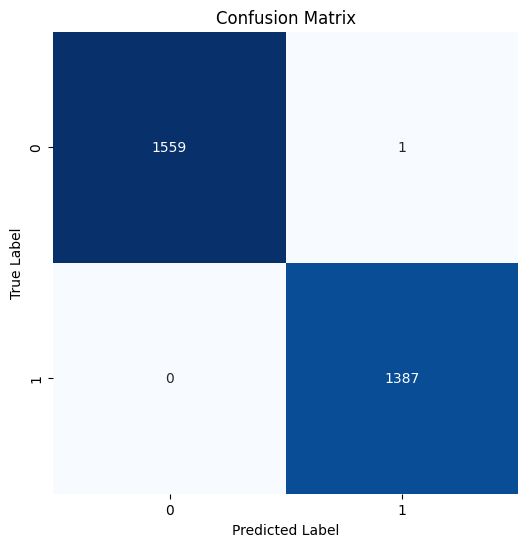


Classification Report:
              precision    recall  f1-score   support

   Non-human       1.00      1.00      1.00      1560
       Human       1.00      1.00      1.00      1387

    accuracy                           1.00      2947
   macro avg       1.00      1.00      1.00      2947
weighted avg       1.00      1.00      1.00      2947

Model saved to har_mlx90614_model.pkl

Example prediction with MLX90614 data:
Prediction: Non-human (confidence: 1.00)


In [ ]:
if __name__ == "__main__":
    # Initialize model
    har_model = HARModel()

    # Download and prepare data
    X_train, y_train, X_test, y_test, features = har_model.download_and_prepare_data()

    # Select features relevant for thermal integration
    har_model.selected_features = har_model.select_thermal_relevant_features(features)
    X_train_selected = X_train[:, har_model.selected_features]
    X_test_selected = X_test[:, har_model.selected_features]

    # Add dummy thermal features for training (since the original dataset doesn't have them)
    dummy_thermal_cols = np.random.normal(0, 1, (X_train_selected.shape[0], 6))
    X_train_with_thermal = np.hstack([X_train_selected, dummy_thermal_cols])

    dummy_thermal_cols_test = np.random.normal(0, 1, (X_test_selected.shape[0], 6))
    X_test_with_thermal = np.hstack([X_test_selected, dummy_thermal_cols_test])

    # Train the model
    har_model.train(X_train_with_thermal, y_train)

    # Evaluate the model
    har_model.evaluate(X_test_with_thermal, y_test)

    # Save the model
    har_model.save_model()

    # Example of using the model with MLX90614 data
    print("\nExample prediction with MLX90614 data:")

    # Example accelerometer/gyroscope data (would come from your sensors)
    example_har_features = X_test[0]

    # Example MLX90614 data (would come from your thermal sensor)
    example_thermal_data = {
        'ambient_temp': 25.0,    # Room temperature in Celsius
        'object_temp': 36.5,     # Object temperature in Celsius (human body temp)
        'temp_variance': 0.2     # Variance in readings
    }

    # Make prediction
    prediction, probability = har_model.predict_with_thermal(example_har_features, example_thermal_data)

    if prediction == 1:
        print(f"Prediction: Human (confidence: {probability:.2f})")
    else:
        print(f"Prediction: Non-human (confidence: {probability:.2f})")

    # Uncomment to run the real-time example (requires MLX90614 sensor)
    # mlx90614_example()